In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

[09:36:20.347] INFO   DiVAE                                             Willkommen!
[09:36:20.348] INFO   DiVAE                                             Loading configuration.


In [5]:
from utils import *

In [6]:
import numpy as np

# DWave imports
from dwave.system import DWaveSampler, LeapHybridSampler

2022-02-18 09:36:22,191 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[09:36:22.191] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [ ]:
import neal

QPU Access

In [24]:
qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-18 09:56:53,125 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[09:56:53.125] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-18 09:56:54,012 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[09:56:54.012] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-18 09:56:54,147 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[09:56:54.147] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')


In [25]:
leap_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-18 09:56:54,243 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[09:56:54.243] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-18 09:56:54,888 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[09:56:54.888] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-18 09:56:54,984 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[09:56:54.984] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')


In [26]:
sa_sampler = neal.SimulatedAnnealingSampler()

NameError: name 'neal' is not defined

Define the classical RBM

In [27]:
_NUM_NODES = 8

In [28]:
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)

In [29]:
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

Test the QPU sampler

In [ ]:
left, right = crbm.visible_qubit_idxs, crbm.hidden_qubit_idxs
edge_list = crbm.pruned_edge_list

In [ ]:
# Check all qubits and coupling exist on the QPU
all(qubit in qpu_sampler.nodelist for qubit in (left+right)) and all(edge in qpu_sampler.edgelist for edge in edge_list)

In [ ]:
# Check all qubits and coupling exist on the hybrid sampler
all(qubit in leap_sampler.nodelist for qubit in (left+right)) and all(edge in leap_sampler.edgelist for edge in edge_list)

In [ ]:
crbm_left_bias, crbm_right_bias = crbm.visible_bias, crbm.hidden_bias

In [ ]:
qubits = left + right
biases = crbm_left_bias + crbm_right_bias

In [ ]:
h = {qubit:bias for qubit,bias in zip(qubits, biases)}

In [ ]:
visible_idx_map_inv = {i:visible_qubit_idx for i, visible_qubit_idx in enumerate(left)}
hidden_idx_map_inv = {i:hidden_qubit_idx for i, hidden_qubit_idx in enumerate(right)}

In [ ]:
crbm_weights = crbm.weights.detach().cpu().numpy()

In [ ]:
J = {}
for row in range(crbm_weights.shape[0]):
    for col in range(crbm_weights.shape[1]):
        if crbm_weights[row][col] != 0:
            J[(visible_idx_map_inv[row], hidden_idx_map_inv[col])] = crbm_weights[row][col]

In [ ]:
response = leap_sampler.sample_ising(h, J, num_reads=1000)

Method to batch the samples collected by the DWave sampler to be used in the same way as classical MCMC sampler

In [31]:
def batch_dwave_samples(response):
    """
    sampler.sample_ising() method returns a nested SampleSet structure
    with unique samples, energies and number of occurences stored in dict 
    
    Extract those values and construct a batch_size * (num_vis+num_hid) numpy array
    
    Returns:
        batch_samples : batch_size * (num_vis+num_hid) numpy array of samples collected by the DWave sampler
        batch_energies : batch_size * 1 numpy array of energies of samples
    """
    samples = []
    energies = []
    
    for sample_info in response.data():
        uniq_sample = list(sample_info[0].values())
        sample_energy = sample_info[1]
        num_occurences = sample_info[2]
        
        samples.extend([uniq_sample]*num_occurences)
        energies.extend([sample_energy]*num_occurences)
        
    batch_samples = np.array(samples)
    batch_energies = np.array(energies).reshape(-1)
        
    return batch_samples, batch_energies

Define the temperature estimation procedure

In [23]:
def beta_estimation(num_iterations=100, lr=0.01, beta_init=5., n_reads=1000, crbm_sampler=None, dwave_sampler=None):
    assert crbm_sampler is not None
    assert dwave_sampler is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm = crbm_sampler.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    n_vis = len(crbm.visible_qubit_idxs)
    qubit_idxs = crbm.visible_qubit_idxs+crbm.hidden_qubit_idxs
    
    visible_idx_map_inv = {i:visible_qubit_idx for i, visible_qubit_idx in enumerate(crbm.visible_qubit_idxs)}
    hidden_idx_map_inv = {i:hidden_qubit_idx for i, hidden_qubit_idx in enumerate(crbm.hidden_qubit_idxs)}
    
    for i in range(num_iterations):
        dwave_weights, dwave_vbias, dwave_hbias = crbm_weights/beta, crbm_vbias/beta, crbm_hbias/beta
        dwave_weights_np = dwave_weights.detach().cpu().numpy()
        
        biases = torch.cat((dwave_vbias, dwave_hbias)).detach().cpu().numpy()
        h = {qubit_idx:bias for qubit_idx, bias in zip(qubit_idxs, biases)}
        J = {}
        for row in range(dwave_weights_np.shape[0]):
            for col in range(dwave_weights_np.shape[1]):
                if dwave_weights_np[row][col] != 0:
                    J[(visible_idx_map_inv[row], hidden_idx_map_inv[col])] = dwave_weights_np[row][col]
        
        response = dwave_sampler.sample_ising(h, J, num_reads=n_reads)
        dwave_samples, dwave_energies = batch_dwave_samples(response)
        
        dwave_samples = torch.from_numpy(np.where(dwave_samples == -1., 0., 1.)).float()
        dwave_vis, dwave_hid = dwave_samples[:, :n_vis], dwave_samples[:, n_vis:]
        
        dwave_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, dwave_vis, dwave_hid)
        dwave_energy_exp = torch.mean(dwave_energy_exp, axis=0)
        
        crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
        crbm_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, crbm_vis, crbm_hid)
        crbm_energy_exp = torch.mean(crbm_energy_exp, axis=0)
        
        beta = beta + lr*(float(crbm_energy_exp) - float(dwave_energy_exp))
        betas.append(beta)
    
    return betas

In [8]:
def plot_betas(betas):
    """
    Plot the estimates of beta during the beta estimation procedure   
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    plt.plot(np.arange(len(betas)), betas)
    
    ax.set_xlabel("Iteration", fontsize=60)
    ax.set_ylabel("Beta", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    
    plt.show()
    plt.close()

In [ ]:
betas = beta_estimation(num_iterations=100, lr=0.1, n_reads=100, beta_init=5., crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

In [ ]:
plot_betas(betas)

In [11]:
def beta_estimation_classical(num_iterations=100, lr=0.01, beta_init=5., n_reads=1000, crbm_sampler_1=None, crbm_sampler_2=None):
    assert crbm_sampler_1 is not None and crbm_sampler_2 is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm_1 = crbm_sampler_1.get_rbm()
    crbm_weights_1, crbm_vbias_1, crbm_hbias_1 = crbm_1.weights, crbm_1.visible_bias, crbm_1.hidden_bias
    
    crbm_2 = crbm_sampler_2.get_rbm()
    
    for i in range(num_iterations):
        crbm_2._weights = torch.nn.Parameter(crbm_weights_1/beta)
        crbm_2._visible_bias = torch.nn.Parameter(crbm_vbias_1/beta)
        crbm_2._hidden_bias = torch.nn.Parameter(crbm_hbias_1/beta)
        
        crbm_vis_1, crbm_hid_1 = crbm_sampler_1.block_gibbs_sampling()
        crbm_energy_exp_1 = sample_energies(crbm_2, crbm_vis_1, crbm_hid_1)
        crbm_energy_exp_1 = torch.mean(crbm_energy_exp_1, axis=0)
        
        crbm_vis_2, crbm_hid_2 = crbm_sampler_2.block_gibbs_sampling()
        crbm_energy_exp_2 = sample_energies(crbm_2, crbm_vis_2, crbm_hid_2)
        crbm_energy_exp_2 = torch.mean(crbm_energy_exp_2, axis=0)        
        
        beta = beta + lr*(float(crbm_energy_exp_1) - float(crbm_energy_exp_2))
        betas.append(beta)
    
    return betas

In [12]:
_NUM_NODES = 8
crbm_1 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_1 = PCD(batch_size=1024, RBM=crbm_1, n_gibbs_sampling_steps=100)

crbm_2 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_2 = PCD(batch_size=1024, RBM=crbm_2, n_gibbs_sampling_steps=100)

In [32]:
betas = beta_estimation_classical(num_iterations=200, beta_init=1.5, lr=0.01, crbm_sampler_1=crbm_sampler_1, crbm_sampler_2=crbm_sampler_2)

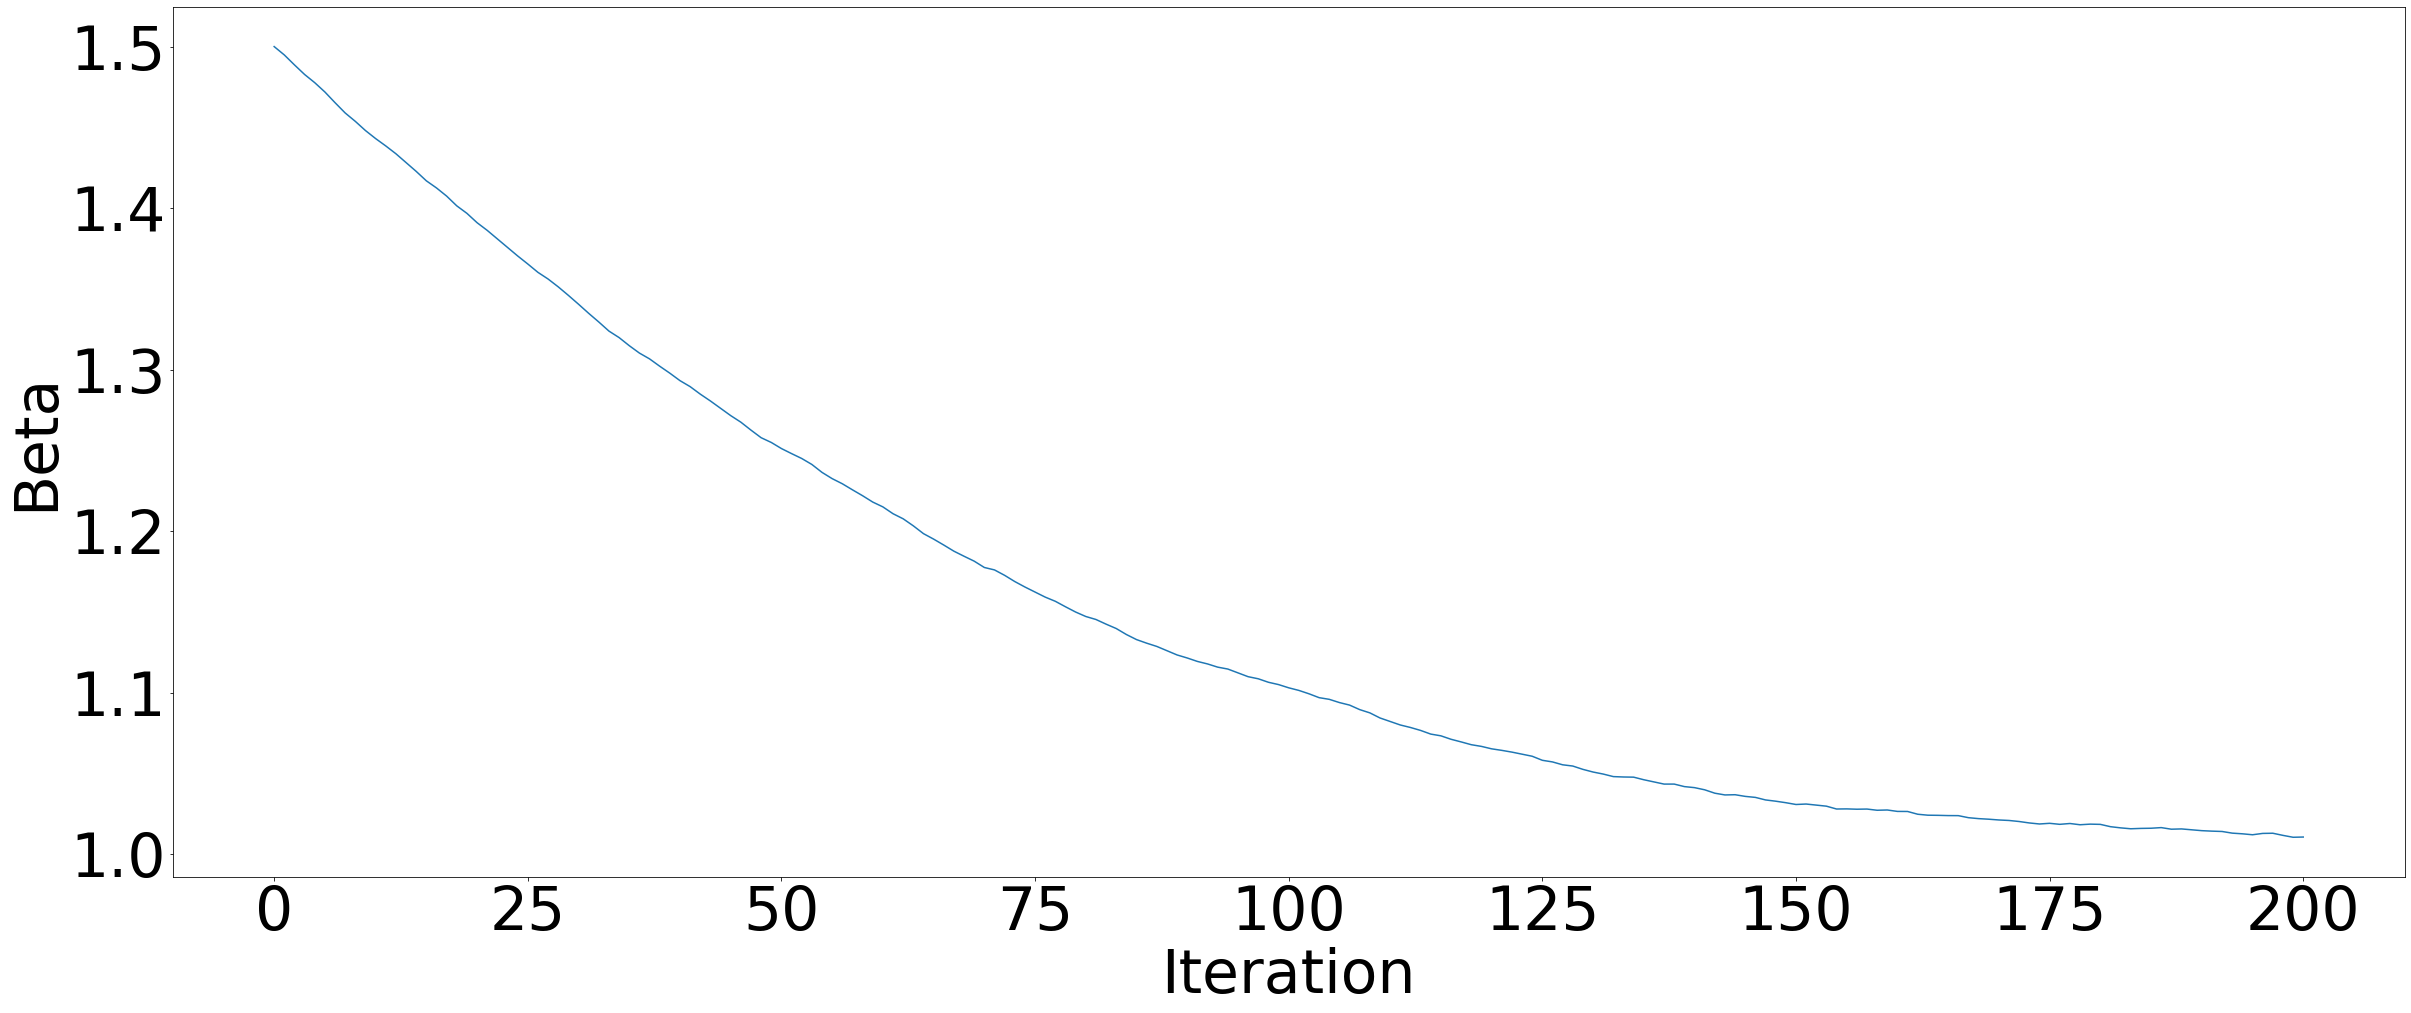

In [33]:
plot_betas(betas)

In [34]:
betas = beta_estimation(num_iterations=100, n_reads=100, lr=0.01, beta_init=1.5, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

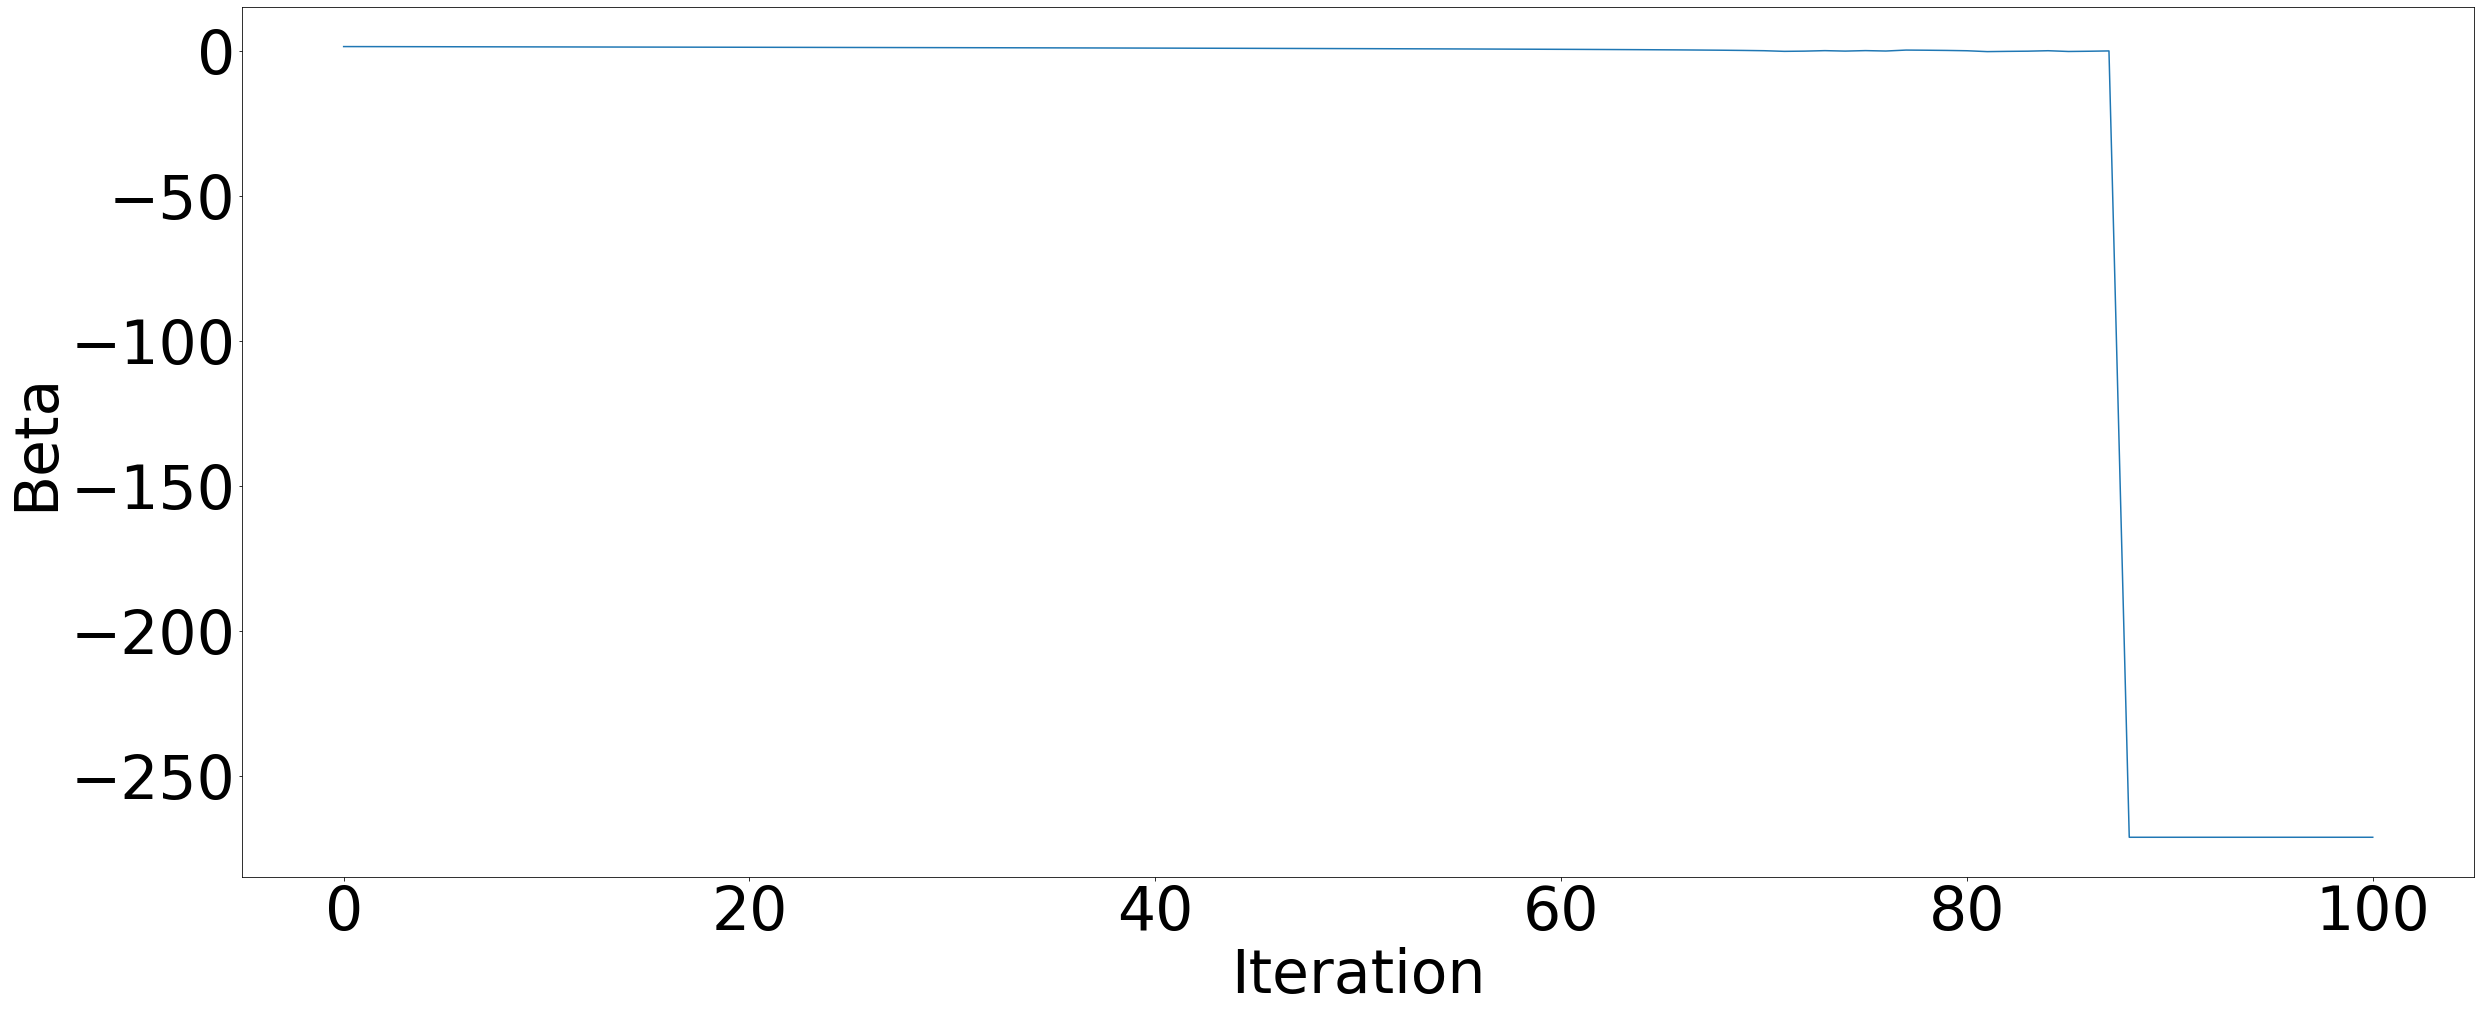

In [35]:
plot_betas(betas)

In [38]:
betas = beta_estimation(num_iterations=50, n_reads=100, lr=0.01, beta_init=1.5, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

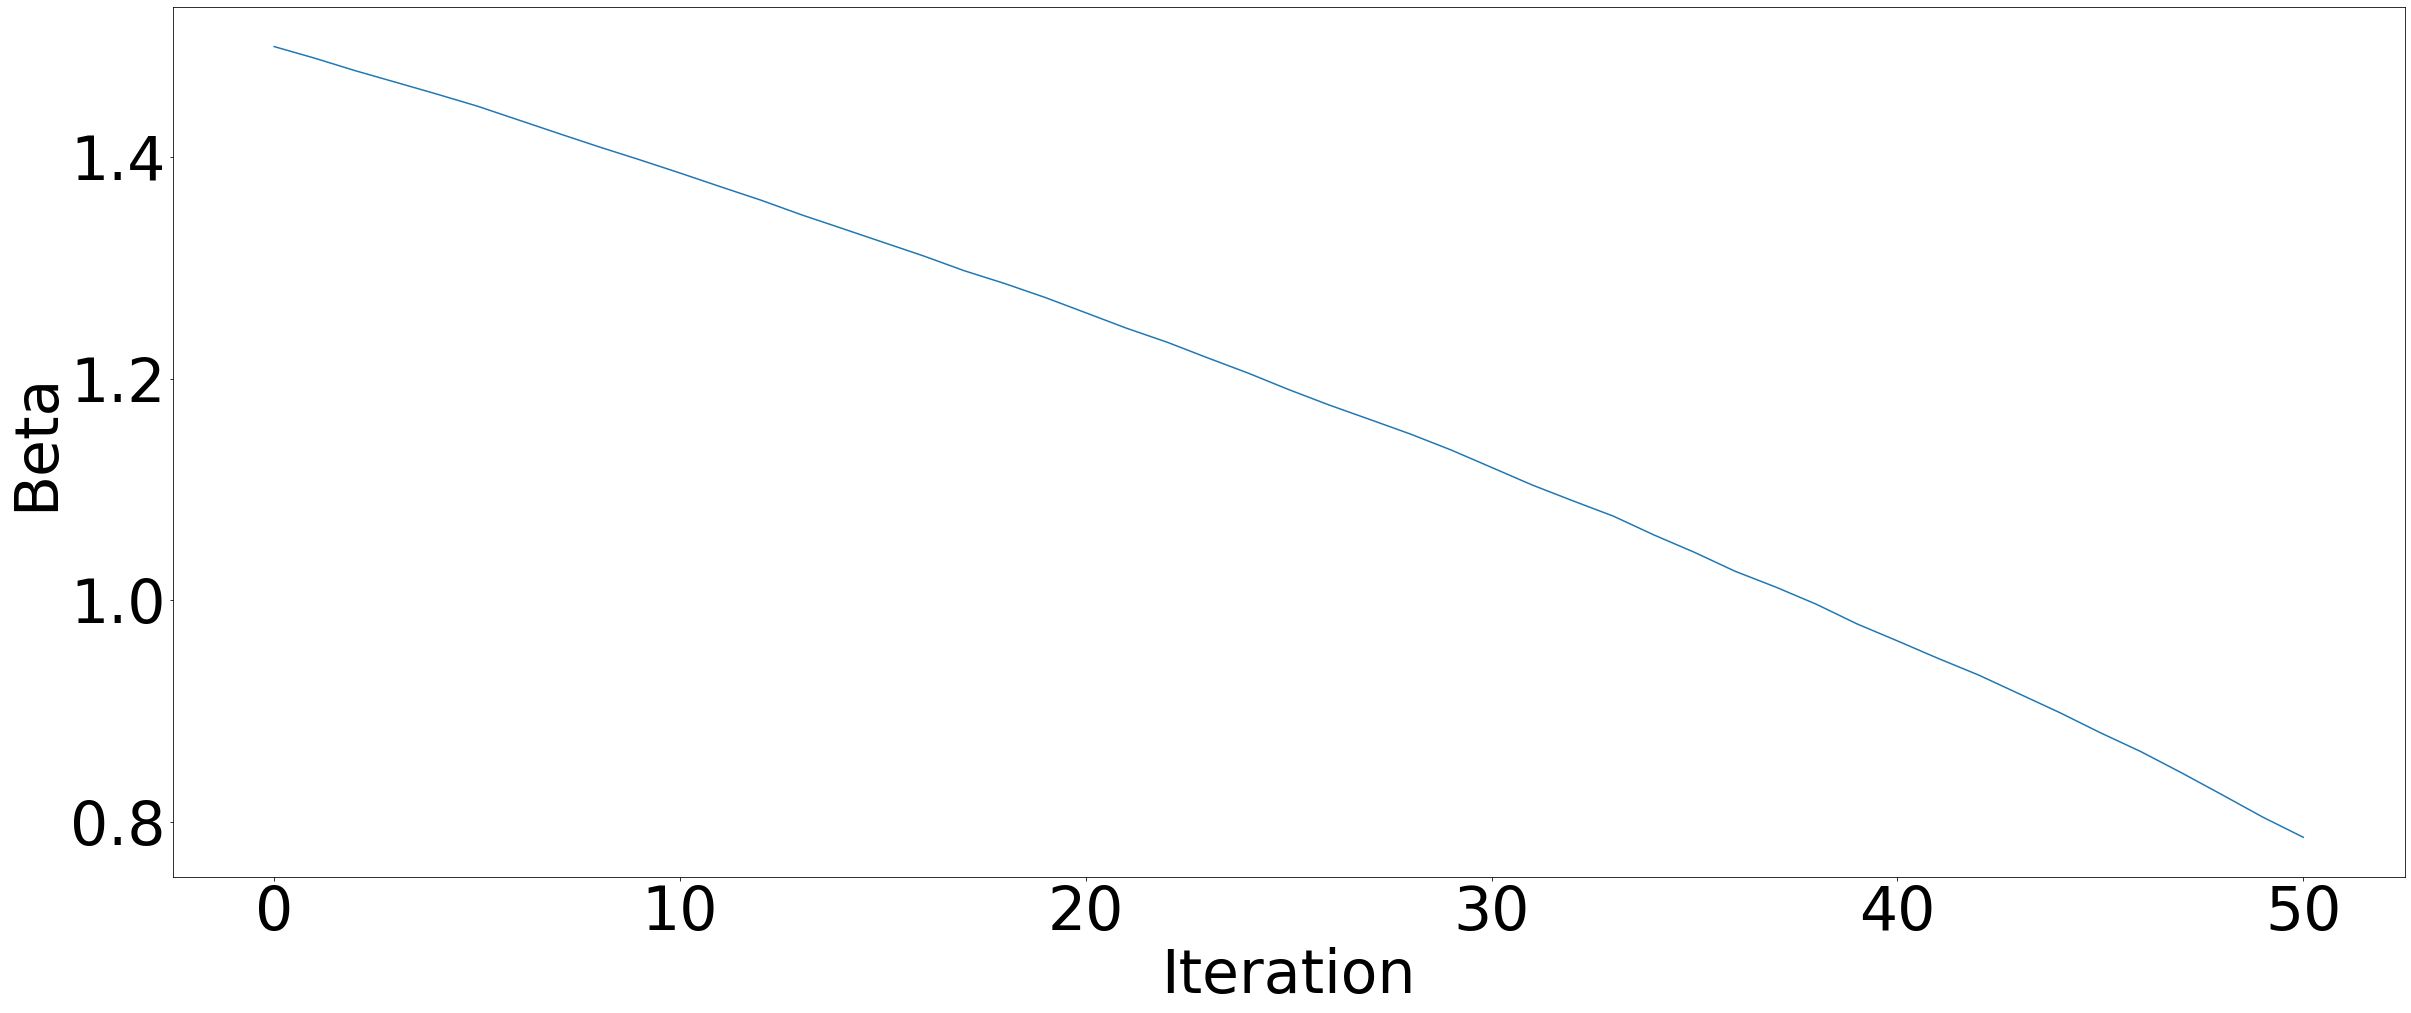

In [39]:
plot_betas(betas)

In [40]:
_NUM_NODES = 128
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

In [41]:
betas = beta_estimation(num_iterations=50, n_reads=1024, lr=0.01, beta_init=1.5, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

BinaryQuadraticModelStructureError: Problem graph incompatible with solver. Please use 'EmbeddingComposite' to map the problem graph to the solver.